<a href="https://colab.research.google.com/github/xodud5654/PDM05/blob/main/py-tensorflow/DL4-autoML/private_file/private_file.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [97]:
# from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import  MobileNetV2, preprocess_input
import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import tensorflow as tf
from keras.utils import np_utils
from keras.models import load_model
from keras.datasets import cifar10
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# import cv2
print(tf.__version__)

2.7.0


In [98]:
tf.keras.backend.clear_session()  # For memory

# GPU check
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print("#### ", len(gpus), "Physical GPUs,",
                 len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print('#### No CUDA supported GPU in this computer.')

####  1 Physical GPUs, 1 Logical GPUs


In [99]:
from keras.datasets import cifar10
# load dataset
(trainX, trainy), (testX, testy) = cifar10.load_data()
# summarize loaded dataset
# print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
# print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

from sklearn.model_selection import train_test_split
X_train, X_test,y_train , y_test = train_test_split(trainX,trainy,test_size=0.1,stratify=trainy, random_state=42)
print(X_test.shape, y_test.shape)
X_train, y_train,X_test, y_test = X_test,y_test, testX, testy



print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (X_test.shape, y_test.shape))

(5000, 32, 32, 3) (5000, 1)
Train: X=(5000, 32, 32, 3), y=(5000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


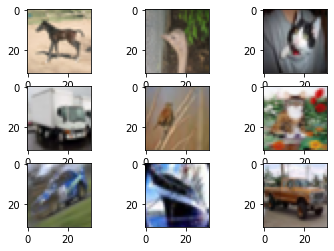

In [100]:
img_rows, img_cols , channels= 32,32,3
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train[i])
plt.show()

In [101]:
# set up image augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    #zoom_range=0.3
    )
datagen.fit(X_train)

In [102]:
#reshape into images
img_rows,img_cols, channels = 32,32,3

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, channels)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, channels)
input_shape = (img_rows, img_cols, 1)
print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

x_train shape: (5000, 32, 32, 3)
5000 train samples
10000 test samples


In [103]:
#convert integers to float; normalise and center the mean
X_train=X_train.astype("float32")  
X_test=X_test.astype("float32")
# mean=np.mean(X_train)
# std=np.std(X_train)
# X_test=(X_test-mean)/std
# X_train=(X_train-mean)/std

In [104]:

num_classes=10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
# y_test = np.asarray(y_test).astype('float32').reshape((-1,1))


In [105]:
# plotting helper function
def plothist(hist):
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [106]:
TL_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
TL_base.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [107]:
# build and compile the model  (roughly following the VGG paper)
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

#reg=l2(1e-4)   # L2 or "ridge" regularisation
reg=None
num_filters=32
ac='relu'
opt = tf.keras.optimizers.SGD(learning_rate=5e-4)

drop_dense=0.5
drop_conv=0

model = Sequential()

# model.add(Conv2D(num_filters, (3, 3), activation=ac, kernel_regularizer=reg, input_shape=(img_rows, img_cols, channels),padding='same'))
# model.add(BatchNormalization(axis=-1))
# model.add(Conv2D(num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
# model.add(BatchNormalization(axis=-1))
# model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 16x16x3xnum_filters
# model.add(Dropout(drop_conv))

# model.add(Conv2D(2*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
# model.add(BatchNormalization(axis=-1))
# model.add(Conv2D(2*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
# model.add(BatchNormalization(axis=-1))
# model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 8x8x3x(2*num_filters)
# model.add(Dropout(drop_conv))

# model.add(Conv2D(4*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
# model.add(BatchNormalization(axis=-1))
# model.add(Conv2D(4*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
# model.add(BatchNormalization(axis=-1))
# model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 4x4x3x(4*num_filters)
# model.add(Dropout(drop_conv))
# model.add(Dense(512, activation=ac))
# model.add(BatchNormalization())
# model.add(Dropout(drop_dense))
# model.add(Dense(num_classes, activation='softmax'))
model.add(keras.Input(shape=(32,32,3)))
model.add(layers.UpSampling2D((7,7)))  # 32*7 = 224
model.add(TL_base)
model.add(layers.GlobalAveragePooling2D()) # (7,7,2048) => (2048,)
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(num_classes, activation='softmax'))





model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt)

In [108]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d (UpSampling2D  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                          

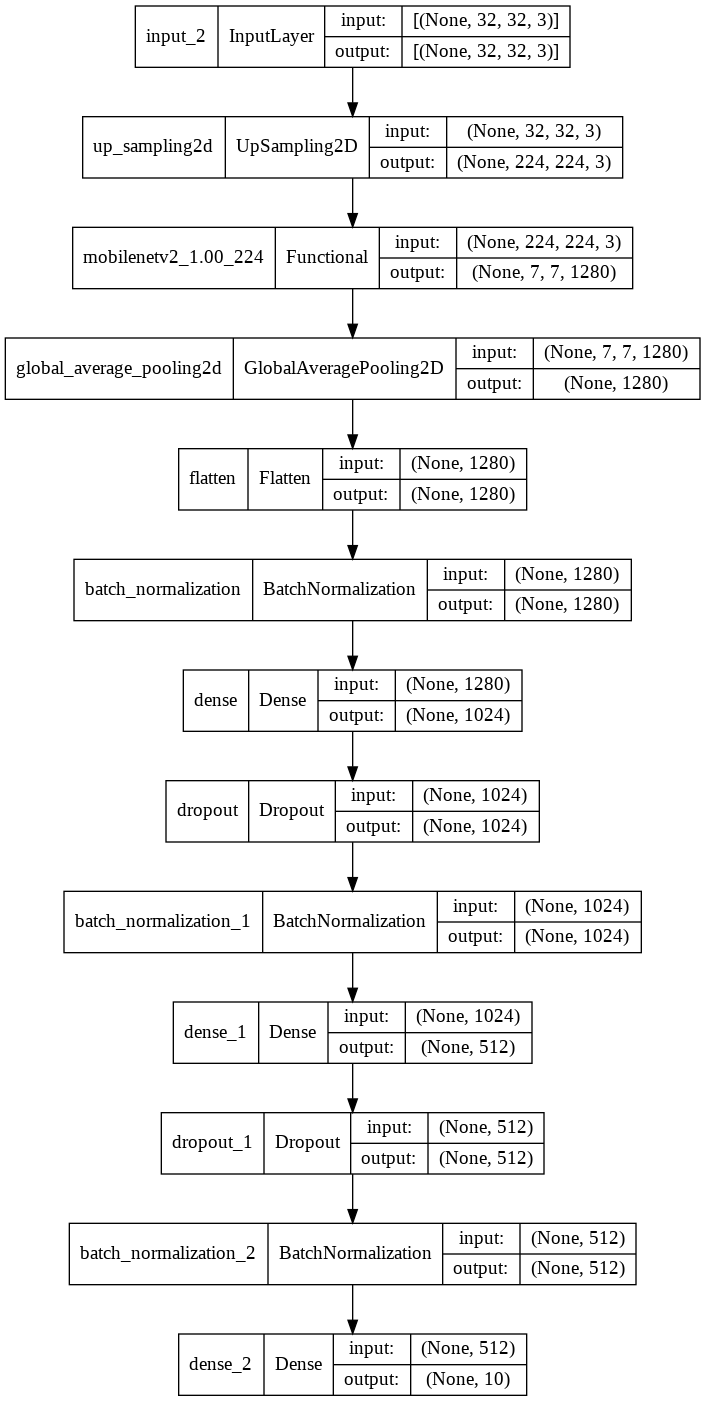

In [109]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [110]:
from tensorflow.keras import layers, models, callbacks

mc_callback = callbacks.ModelCheckpoint(filepath="./model/cifar10_pct100_mobilenetV2S_SGD_best_weights.{epoch:03d}-{val_accuracy:.4f}.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True)
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', 
                            mode='max', verbose=1, patience=5)

In [111]:
train = datagen.flow(X_train, y_train, batch_size=16,seed=1234)

In [116]:
# history = model.fit(train, 
#                     epochs=50, batch_size=32, 
#                     validation_data=(X_test, y_test),
#                     callbacks=[mc_callback,es_callback])
epochs = 500
BATCH_SIZE = 50
history = model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE, seed=1234), # BATCH_SIZE = 50
                 steps_per_epoch=X_train.shape[0]//BATCH_SIZE, 
                 epochs=epochs, verbose=1, 
                 callbacks=[mc_callback, es_callback], 
                 validation_data=(X_test,y_test))    

Epoch 1/500
100/100 [==============================] - ETA: 0s - loss: 1.0601 - accuracy: 0.6376

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 77s 764ms/step - loss: 1.0601 - accuracy: 0.6376 - val_loss: 0.9630 - val_accuracy: 0.6786
Epoch 2/500
100/100 [==============================] - 76s 762ms/step - loss: 1.0246 - accuracy: 0.6530 - val_loss: 0.9306 - val_accuracy: 0.6894
Epoch 3/500
100/100 [==============================] - 94s 941ms/step - loss: 1.0182 - accuracy: 0.6578 - val_loss: 0.9092 - val_accuracy: 0.6950
Epoch 4/500
100/100 [==============================] - 76s 765ms/step - loss: 1.0014 - accuracy: 0.6586 - val_loss: 0.8947 - val_accuracy: 0.6994
Epoch 5/500
100/100 [==============================] - 76s 759ms/step - loss: 0.9514 - accuracy: 0.6752 - val_loss: 0.8703 - val_accuracy: 0.7085
Epoch 6/500
100/100 [==============================] - 76s 760ms/step - loss: 0.9542 - accuracy: 0.6802 - val_loss: 0.8530 - val_accuracy: 0.7152
Epoch 7/500
100/100 [==============================] - 76s 761ms/step - loss: 0.9184 - accuracy: 0.6916 - val_loss: 0.8308 - val_accurac

In [117]:
model.evaluate(X_test, y_test, batch_size=50)

tf.keras.backend.clear_session()  # For memory
TL_base.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(TL_base.layers))

200/200 [==============================] - 25s 117ms/step - loss: 0.4434 - accuracy: 0.8596
Number of layers in the base model:  154


In [118]:
# Fine-tune from this layer onwards
fine_tune_at = 107  # 81, 107 for mobilenetV2

# Freeze all the layers before the `fine_tune_at` layer
for layer in TL_base.layers[:fine_tune_at]:
  layer.trainable =  False

In [120]:
# Compile model
model.compile(optimizer=opt, 
                loss='categorical_crossentropy',  # sparse_categorical_crossentropy
                metrics = ['accuracy'])

In [121]:
history_dict = history.history
loss = history_dict['loss']

INITIAL_EPOCHS = len(loss)
FINE_TUNE_EPOCHS = 100
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS #

In [122]:
# history_fine = model.fit(train,
#                     epochs=TOTAL_EPOCHS, 
#                     initial_epoch=INITIAL_EPOCHS,
#                     batch_size=50, 
#                     validation_data=(X_test, y_test),
#                     callbacks=[mc_callback,es_callback])

history_fine = model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE, seed=1234), # BATCH_SIZE = 50
                 steps_per_epoch=X_train.shape[0]//BATCH_SIZE, 
                 initial_epoch=INITIAL_EPOCHS,
                 epochs=epochs, verbose=1, 
                 callbacks=[mc_callback, es_callback], 
                 validation_data=(X_test,y_test))   

Epoch 120/500
100/100 [==============================] - 46s 414ms/step - loss: 0.2693 - accuracy: 0.9120 - val_loss: 0.4416 - val_accuracy: 0.8596
Epoch 121/500
100/100 [==============================] - 40s 401ms/step - loss: 0.2705 - accuracy: 0.9134 - val_loss: 0.4440 - val_accuracy: 0.8603
Epoch 122/500
100/100 [==============================] - 40s 401ms/step - loss: 0.2546 - accuracy: 0.9186 - val_loss: 0.4450 - val_accuracy: 0.8591
Epoch 123/500
100/100 [==============================] - 40s 401ms/step - loss: 0.2502 - accuracy: 0.9202 - val_loss: 0.4436 - val_accuracy: 0.8599
Epoch 124/500
100/100 [==============================] - 40s 400ms/step - loss: 0.2580 - accuracy: 0.9162 - val_loss: 0.4457 - val_accuracy: 0.8598
Epoch 125/500
100/100 [==============================] - 40s 400ms/step - loss: 0.2571 - accuracy: 0.9170 - val_loss: 0.4492 - val_accuracy: 0.8599
Epoch 126/500
100/100 [==============================] - 40s 400ms/step - loss: 0.2564 - accuracy: 0.9164 - val_

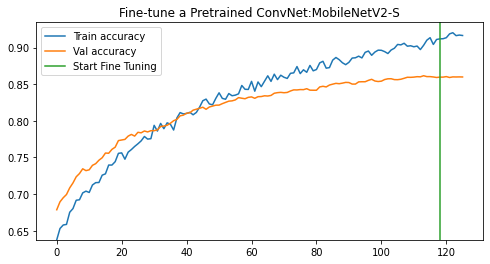

In [123]:
# Display training curve

acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

plt.figure(figsize=(8, 4))

plt.plot(acc, label='Train accuracy')
plt.plot(val_acc, label='Val accuracy')
# plt.ylim([0.8, 1])
plt.plot([INITIAL_EPOCHS-1, INITIAL_EPOCHS-1], plt.ylim(ymin=acc[0]), label='Start Fine Tuning')
plt.title("Fine-tune a Pretrained ConvNet:MobileNetV2-S")
plt.legend(loc='upper left')

plt.show()

In [124]:
## cifar10_pct100_mobilenetV2S_SGD_best_weights.025-0.8155.hdf5

from keras.models import load_model

# returns a compiled model
# identical to the previous one
model = load_model('./model/cifar10_pct100_mobilenetV2S_SGD_best_weights.114-0.8615.hdf5')

In [125]:
y_test_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix
y_test_pred=np.argmax(y_test_pred, axis=1)
y_test=np.argmax(y_test, axis=1)
print(confusion_matrix(y_test, y_test_pred))


[[902   4  17   6   5   1   5   8  29  23]
 [  6 935   1   0   1   0   3   1   3  50]
 [ 35   0 795  18  31  23  75  16   4   3]
 [ 13   2  10 666  36 114 123  22   8   6]
 [ 12   0  25  11 813  11  72  55   1   0]
 [  1   1  17  93  29 779  38  39   1   2]
 [  6   1   9  10   6   2 965   0   1   0]
 [ 11   0   5  13  16  28  15 906   0   6]
 [ 43  23   4   1   2   0   6   1 897  23]
 [  6  28   1   2   0   0   0   1   5 957]]


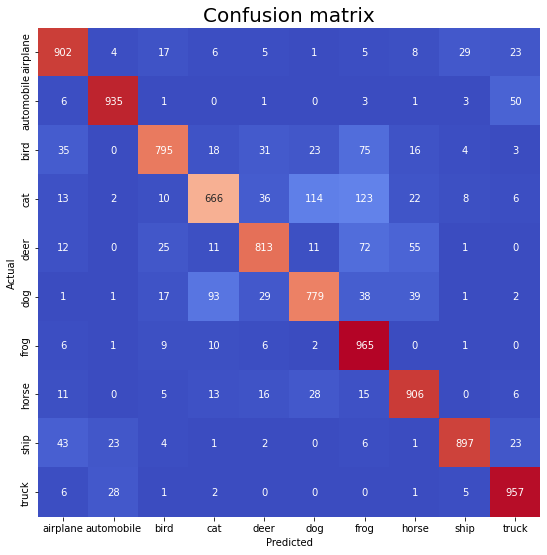

In [127]:
cm = confusion_matrix(y_test, y_test_pred)
# import seaborn as sns

# plt.figure(figsize=(12,10))
# plt.title("confusion matrix", fontsize=20)
# sns.heatmap(cm,annot=True,cmap='Blues', fmt='g')
# classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# plt.xticks(np.arange(0.5,10.5,1),classes)
# plt.yticks(np.arange(0.5,10.5,1),classes)
# plt.xlabel("predicted labels",fontsize=15)
# plt.ylabel("True labels",fontsize=15)

import seaborn as sns
plt.figure(figsize=(9,9))
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
sns.heatmap(cm, cbar=False, xticklabels=classes, yticklabels=classes, fmt='d', annot=True, cmap=plt.cm.coolwarm)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix', fontsize=20)
plt.show()


In [130]:
from sklearn.metrics import f1_score, accuracy_score

print("f1_score : ",f1_score(y_test, y_test_pred,average="macro"))

print("accuracy_score : ",accuracy_score(y_test, y_test_pred))

f1_score :  0.8602248526773323
accuracy_score :  0.8615
